# import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import time

In [99]:
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# DATA PREPARATION
## Load the training data and test data

In [194]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_FD003 = pd.read_table("./CMAPSSData/train_FD003.txt", header=None, delim_whitespace=True)
train_FD003.columns = column_name
# Test 文件中的cycle数 并不是到死的
test_FD003 = pd.read_table("./CMAPSSData/test_FD003.txt", header=None, delim_whitespace=True)
test_FD003.columns = column_name

# load RUL data 真正的最后循环数存放在这里
RUL_FD003 = pd.read_table("./CMAPSSData/RUL_FD003.txt", header=None, delim_whitespace=True)

In [195]:
train_FD003.describe()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000
mean,48.63188,139.07706,-0.00002,0.00001,100.00000,518.67000,642.45786,1588.07918,1404.47121,14.62000,21.59584,555.14381,2388.07155,9064.11081,1.30123,47.41571,523.05087,2388.07164,8144.20292,8.39618,0.03000,392.56655,2388.00000,100.00000,38.98855,23.39302
std,29.34899,98.84668,0.00219,0.00029,0.00000,0.00000,0.52303,6.81042,9.77318,0.00000,0.01812,3.43734,0.15828,19.98029,0.00348,0.30007,3.25531,0.15812,16.50412,0.06051,0.00000,1.76146,0.00000,0.00000,0.24886,0.14923
min,1.00000,1.00000,-0.00860,-0.00060,100.00000,518.67000,640.84000,1564.30000,1377.06000,14.62000,21.45000,549.61000,2386.90000,9017.98000,1.29000,46.69000,517.77000,2386.93000,8099.68000,8.15630,0.03000,388.00000,2388.00000,100.00000,38.17000,22.87260
25%,23.00000,62.00000,-0.00150,-0.00020,100.00000,518.67000,642.08000,1583.28000,1397.18750,14.62000,21.58000,553.11000,2388.00000,9051.92000,1.30000,47.19000,521.15000,2388.01000,8134.51000,8.36060,0.03000,391.00000,2388.00000,100.00000,38.83000,23.29620
50%,47.00000,124.00000,0.00000,-0.00000,100.00000,518.67000,642.40000,1587.52000,1402.91000,14.62000,21.60000,554.05000,2388.07000,9060.01000,1.30000,47.36000,521.98000,2388.07000,8141.20000,8.39830,0.03000,392.00000,2388.00000,100.00000,38.99000,23.39160
75%,74.00000,191.00000,0.00150,0.00030,100.00000,518.67000,642.79000,1592.41250,1410.60000,14.62000,21.61000,556.04000,2388.14000,9070.09250,1.30000,47.60000,523.84000,2388.14000,8149.23000,8.43700,0.03000,394.00000,2388.00000,100.00000,39.14000,23.48330
max,100.00000,525.00000,0.00860,0.00070,100.00000,518.67000,645.11000,1615.39000,1441.16000,14.62000,21.61000,570.49000,2388.60000,9234.35000,1.32000,48.44000,537.40000,2388.61000,8290.55000,8.57050,0.03000,399.00000,2388.00000,100.00000,39.85000,23.95050


# Feature extention

### 去掉不变的sensor的值和setting

In [196]:
train_FD003 = train_FD003.drop(['s1','s5','s16','s18','s19','setting3','setting1','setting2'],axis = 1)

In [197]:
test_FD003 = test_FD003.drop(['s1','s5','s16','s18','s19','setting3','setting1','setting2'],axis = 1)

## Difference with previous row

In [198]:
def cal_diff(df, sensor_name,diff_periods = 20):
    _id =1
    sensor_diff = []
    sensor_diff_temp = []
    for _id in set(df['engine_id']):
        trainFD003_of_one_id =  df[df['engine_id'] == _id]
        s = pd.Series(trainFD003_of_one_id[sensor_name])
        #判断每一个数列的长度是否大于diff_periods
        if len(s)>diff_periods:
            sensor_diff_temp=s.diff(periods=diff_periods)
            # 第0到39 应该是每一个值-第一个值
            for i in range(diff_periods):
                sensor_diff.append(s.iloc[i]-s.iloc[0])
            # 第40个值之后应该是每一个值-向前推40位的值
            for j in range (len(s)-diff_periods):
                sensor_diff.append(sensor_diff_temp.iloc[diff_periods+j])
        else:
            for h in range(len(s)):
                sensor_diff.append(s.iloc[h]-s.iloc[0])
    return sensor_diff

In [199]:
#get all the names of sensors
list(train_FD003.columns)
sensor_name = list(train_FD003.columns)
sensor_name = sensor_name[2:]
sensor_name

['s2',
 's3',
 's4',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's17',
 's20',
 's21']

In [200]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(train_FD003,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    train_FD003[name] = diff

In [201]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(test_FD003,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    test_FD003[name] = diff

In [202]:
test_FD003

,engine_id,cycle,s2,s3,s4,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s17,s20,s21,s2_diff,s3_diff,s4_diff,s6_diff,s7_diff,s8_diff,s9_diff,s10_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
0,1,1,641.94000,1581.93000,1396.93000,21.58000,554.56000,2387.93000,9048.65000,1.30000,47.09000,521.89000,2387.94000,8133.48000,8.37600,391,39.07000,23.44680,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,1,2,642.02000,1584.86000,1398.90000,21.58000,554.10000,2387.94000,9046.53000,1.30000,47.08000,521.85000,2388.01000,8137.44000,8.40620,391,39.04000,23.48070,0.08000,2.93000,1.97000,0.00000,-0.46000,0.01000,-2.12000,0.00000,-0.01000,-0.04000,0.07000,3.96000,0.03020,0.00000,-0.03000,0.03390
2,1,3,641.68000,1581.78000,1391.92000,21.58000,554.41000,2387.97000,9054.92000,1.30000,47.15000,522.10000,2387.94000,8138.25000,8.35530,391,39.10000,23.42440,-0.26000,-0.15000,-5.01000,0.00000,-0.15000,0.04000,6.27000,0.00000,0.06000,0.21000,0.00000,4.77000,-0.02070,0.00000,0.03000,-0.02240
3,1,4,642.20000,1584.53000,1395.34000,21.59000,554.58000,2387.94000,9055.04000,1.30000,47.26000,522.45000,2387.96000,8137.07000,8.37090,392,38.97000,23.47820,0.26000,2.60000,-1.59000,0.01000,0.02000,0.01000,6.39000,0.00000,0.17000,0.56000,0.02000,3.59000,-0.00510,1.00000,-0.10000,0.03140
4,1,5,642.46000,1589.03000,1395.86000,21.58000,554.16000,2388.01000,9048.59000,1.30000,46.94000,521.91000,2387.97000,8134.20000,8.41460,391,39.09000,23.39500,0.52000,7.10000,-1.07000,0.00000,-0.40000,0.08000,-0.06000,0.00000,-0.15000,0.02000,0.03000,0.72000,0.03860,0.00000,0.02000,-0.05180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,100,243,643.04000,1594.99000,1411.28000,21.58000,561.21000,2388.24000,9088.31000,1.31000,47.61000,529.23000,2388.24000,8162.24000,8.29390,395,39.40000,23.49490,0.51000,1.91000,9.76000,0.00000,2.44000,0.08000,15.46000,0.00000,0.14000,2.56000,0.09000,6.73000,-0.03270,2.00000,0.15000,0.04040
16592,100,244,642.47000,1591.27000,1417.64000,21.58000,561.02000,2388.29000,9085.35000,1.31000,47.75000,529.27000,2388.26000,8163.24000,8.32470,394,39.42000,23.60110,0.49000,-1.68000,10.15000,0.00000,2.57000,0.12000,11.27000,0.01000,0.13000,3.02000,0.10000,10.57000,0.01510,0.00000,0.09000,0.11440
16593,100,245,642.70000,1593.81000,1412.70000,21.58000,561.16000,2388.23000,9084.29000,1.31000,47.60000,529.48000,2388.28000,8162.12000,8.32640,394,39.43000,23.54820,-0.04000,2.81000,3.34000,0.01000,2.22000,0.10000,9.95000,0.01000,0.12000,3.89000,0.16000,5.12000,-0.01290,2.00000,0.29000,-0.02710
16594,100,246,642.19000,1595.63000,1406.58000,21.58000,562.66000,2388.24000,9092.52000,1.31000,47.69000,529.39000,2388.33000,8164.20000,8.29080,395,39.40000,23.66870,-0.65000,6.73000,1.28000,0.00000,4.05000,0.09000,14.02000,0.01000,0.41000,3.11000,0.21000,12.31000,-0.04760,0.00000,0.29000,0.05280


In [203]:
train_FD003.describe()

,engine_id,cycle,s2,s3,s4,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s17,s20,s21,s2_diff,s3_diff,s4_diff,s6_diff,s7_diff,s8_diff,s9_diff,s10_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
count,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000,24720.00000
mean,48.63188,139.07706,642.45786,1588.07918,1404.47121,21.59584,555.14381,2388.07155,9064.11081,1.30123,47.41571,523.05087,2388.07164,8144.20292,8.39618,392.56655,38.98855,23.39302,0.09057,1.23074,1.94499,-0.00015,0.34819,0.02516,3.50128,0.00042,0.06058,0.34243,0.02523,2.62755,-0.00063,0.31990,-0.00039,0.00016
std,29.34899,98.84668,0.52303,6.81042,9.77318,0.01812,3.43734,0.15828,19.98029,0.00348,0.30007,3.25531,0.15812,16.50412,0.06051,1.76146,0.24886,0.14923,0.44386,5.89103,6.27177,0.00414,1.17210,0.09883,8.85008,0.00213,0.16674,1.06453,0.09859,7.10430,0.03192,1.39559,0.15554,0.09207
min,1.00000,1.00000,640.84000,1564.30000,1377.06000,21.45000,549.61000,2386.90000,9017.98000,1.29000,46.69000,517.77000,2386.93000,8099.68000,8.15630,388.00000,38.17000,22.87260,-1.52000,-20.52000,-26.37000,-0.02000,-3.44000,-1.03000,-25.95000,-0.01000,-0.58000,-3.33000,-0.97000,-24.14000,-0.16380,-5.00000,-0.64000,-0.40790
25%,23.00000,62.00000,642.08000,1583.28000,1397.18750,21.58000,553.11000,2388.00000,9051.92000,1.30000,47.19000,521.15000,2388.01000,8134.51000,8.36060,391.00000,38.83000,23.29620,-0.21000,-2.72000,-2.22000,0.00000,-0.38000,-0.01000,-2.08000,0.00000,-0.05000,-0.30000,-0.01000,-1.74000,-0.02190,-1.00000,-0.10000,-0.06190
50%,47.00000,124.00000,642.40000,1587.52000,1402.91000,21.60000,554.05000,2388.07000,9060.01000,1.30000,47.36000,521.98000,2388.07000,8141.20000,8.39830,392.00000,38.99000,23.39160,0.09000,1.19000,1.89000,0.00000,0.14000,0.02000,2.47000,0.00000,0.06000,0.10000,0.02000,1.83000,-0.00020,0.00000,0.00000,0.00000
75%,74.00000,191.00000,642.79000,1592.41250,1410.60000,21.61000,556.04000,2388.14000,9070.09250,1.30000,47.60000,523.84000,2388.14000,8149.23000,8.43700,394.00000,39.14000,23.48330,0.39000,5.21000,6.11000,0.00000,0.79000,0.06000,7.70000,0.00000,0.17000,0.66000,0.06000,5.90000,0.02080,1.00000,0.10000,0.06210
max,100.00000,525.00000,645.11000,1615.39000,1441.16000,21.61000,570.49000,2388.60000,9234.35000,1.32000,48.44000,537.40000,2388.61000,8290.55000,8.57050,399.00000,39.85000,23.95050,2.19000,28.07000,25.92000,0.02000,8.12000,1.02000,81.75000,0.01000,0.82000,7.98000,1.01000,64.82000,0.13760,6.00000,0.62000,0.39500


## standard normalization 

In [204]:
#### standard normalization ####

# Training 因为前两列是没有用的 engine_id cycle
mean = train_FD003.iloc[:, 2:].mean()
std = train_FD003.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
train_FD003.iloc[:, 2:] = (train_FD003.iloc[:, 2:] - mean) / std

# Testing
test_FD003.iloc[:, 2:] = (test_FD003.iloc[:, 2:] - mean) / std

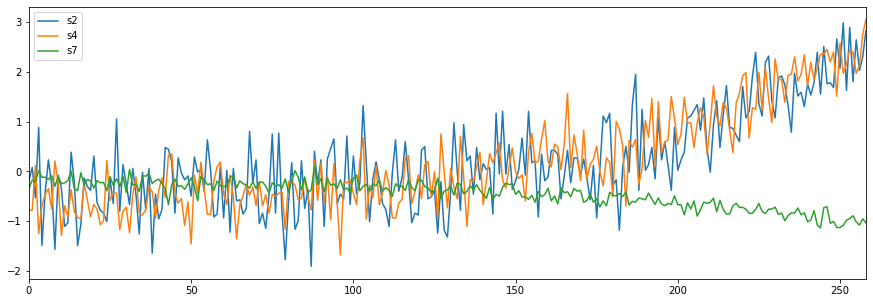

In [205]:
train_FD003[train_FD003["engine_id"]==1][["s2","s4","s7"]].plot(figsize=(15,5));

## Compute the RUL

### Training 

In [206]:
id='engine_id'
# 这个是自己定义的， 拐点在120 ，  120之前视为一样
MAXLIFE = 120
rul = [] # 会逐渐装满所有id的RUL
for _id in set(train_FD003[id]):
    trainFD003_of_one_id =  train_FD003[train_FD003[id] == _id]
    cycle_list = trainFD003_of_one_id['cycle'].tolist()
    # 因为这里是run to end ,所以最大cycle数是确定的
    max_cycle = max(cycle_list)
    # 计算出临界点的位置，没到达临界点的时候，全部保存MAXLIFE，到达临界点的时候，逐点下降！
#     if MAXLIFE >= max_cycle:
#         for i in range(0, len(cycle_list)):
#             tmp = max_cycle-i
#             kink_RUL.append(tmp)
#     else:
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)
    # 每跑完一个id就添加到最后总的rul列表中
    rul.extend(kink_RUL)

train_FD003["RUL"] = rul


### Testing

In [207]:
id='engine_id'
rul = []
for _id_test in set(test_FD003[id]):
    # 真实的RUL， 也就是测试数据最后一个周期所对应的RUL
    true_rul = int(RUL_FD003.iloc[_id_test - 1])
    testFD003_of_one_id =  test_FD003[test_FD003[id] == _id_test]
    cycle_list = testFD003_of_one_id['cycle'].tolist()
    # 那么总的生命周期数=训练集的已有周期数+最后剩下的周期数
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD003["RUL"] = rul

In [208]:
min_shape = np.min([i[0] for i in train_FD003.groupby("engine_id").apply(np.shape).values])
print("训练集中最小的长度是：",min_shape)

训练集中最小的长度是： 145


In [209]:
min_shape = np.min([i[0] for i in test_FD003.groupby("engine_id").apply(np.shape).values])
print("测试集中最小的长度是：",min_shape)

测试集中最小的长度是： 38


In [210]:
train_FD003[train_FD003["engine_id"]==1].head()

,engine_id,cycle,s2,s3,s4,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s17,s20,s21,s2_diff,s3_diff,s4_diff,s6_diff,s7_diff,s8_diff,s9_diff,s10_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-0.18710,-0.71202,-0.78083,0.78157,-0.34149,-0.70477,-0.09714,-0.35347,-0.38559,-0.22759,-0.38985,0.06769,0.46973,-0.88935,0.48801,-0.26351,-0.20405,-0.20892,-0.31012,0.03702,-0.29707,-0.25462,-0.39562,-0.19695,-0.36334,-0.32168,-0.25593,-0.36985,0.01984,-0.22922,0.00251,-0.00177,120
1,1,2,0.08057,-0.49765,-0.77572,0.78157,-0.17275,-0.45206,-0.11666,-0.35347,-0.61887,-0.19380,-0.26336,0.52393,0.72919,-0.32163,0.00582,0.37576,0.11136,0.03892,-0.30215,0.03702,0.19777,0.15012,-0.43969,-0.19695,-0.78316,-0.21835,-0.05306,0.69007,0.51171,0.48732,-0.76901,1.03435,120
2,1,3,-0.53125,-0.84124,0.11652,0.78157,-0.20766,-0.26253,0.30626,-0.35347,-0.65219,-0.31360,-0.45309,0.36155,-0.10041,-0.88935,-0.55674,-0.17505,-0.60959,-0.35830,1.08821,0.03702,0.09539,0.45368,0.51511,-0.19695,-0.84314,-0.58471,-0.35737,0.31283,-1.06101,-0.22922,-1.66911,0.14159,120
3,1,4,0.88358,-0.36256,-1.24844,0.78157,0.01926,-0.45206,0.02298,-0.35347,-0.58554,-0.17229,0.05285,0.14282,-0.13842,-0.32163,-0.11473,-0.65618,1.05762,0.19509,-1.03878,0.03702,0.76087,0.15012,-0.12444,-0.19695,-0.72319,-0.15259,0.45411,-0.19531,-1.13306,0.48732,-0.96188,-0.63821,120
4,1,5,-1.48721,0.08088,-0.69795,0.78157,-0.11748,-0.19935,0.60205,-0.35347,-0.88547,-0.14465,-0.26336,0.21795,-0.15329,-0.32163,0.60856,0.43741,-1.73608,0.70773,-0.18097,0.03702,0.35988,0.55487,1.18290,-0.19695,-1.26296,-0.06804,-0.05306,-0.02077,-1.16126,0.48732,0.19539,1.13426,120


In [211]:
train_FD003

,engine_id,cycle,s2,s3,s4,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s17,s20,s21,s2_diff,s3_diff,s4_diff,s6_diff,s7_diff,s8_diff,s9_diff,s10_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-0.18710,-0.71202,-0.78083,0.78157,-0.34149,-0.70477,-0.09714,-0.35347,-0.38559,-0.22759,-0.38985,0.06769,0.46973,-0.88935,0.48801,-0.26351,-0.20405,-0.20892,-0.31012,0.03702,-0.29707,-0.25462,-0.39562,-0.19695,-0.36334,-0.32168,-0.25593,-0.36985,0.01984,-0.22922,0.00251,-0.00177,120
1,1,2,0.08057,-0.49765,-0.77572,0.78157,-0.17275,-0.45206,-0.11666,-0.35347,-0.61887,-0.19380,-0.26336,0.52393,0.72919,-0.32163,0.00582,0.37576,0.11136,0.03892,-0.30215,0.03702,0.19777,0.15012,-0.43969,-0.19695,-0.78316,-0.21835,-0.05306,0.69007,0.51171,0.48732,-0.76901,1.03435,120
2,1,3,-0.53125,-0.84124,0.11652,0.78157,-0.20766,-0.26253,0.30626,-0.35347,-0.65219,-0.31360,-0.45309,0.36155,-0.10041,-0.88935,-0.55674,-0.17505,-0.60959,-0.35830,1.08821,0.03702,0.09539,0.45368,0.51511,-0.19695,-0.84314,-0.58471,-0.35737,0.31283,-1.06101,-0.22922,-1.66911,0.14159,120
3,1,4,0.88358,-0.36256,-1.24844,0.78157,0.01926,-0.45206,0.02298,-0.35347,-0.58554,-0.17229,0.05285,0.14282,-0.13842,-0.32163,-0.11473,-0.65618,1.05762,0.19509,-1.03878,0.03702,0.76087,0.15012,-0.12444,-0.19695,-0.72319,-0.15259,0.45411,-0.19531,-1.13306,0.48732,-0.96188,-0.63821,120
4,1,5,-1.48721,0.08088,-0.69795,0.78157,-0.11748,-0.19935,0.60205,-0.35347,-0.88547,-0.14465,-0.26336,0.21795,-0.15329,-0.32163,0.60856,0.43741,-1.73608,0.70773,-0.18097,0.03702,0.35988,0.55487,1.18290,-0.19695,-1.26296,-0.06804,-0.05306,-0.02077,-1.16126,0.48732,0.19539,1.13426,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,2.52785,1.16451,2.00946,0.78157,-0.95533,1.12737,0.33579,-0.35347,2.84694,-1.04164,1.44419,-0.37099,1.77527,0.81379,-2.20422,-2.88088,1.44062,-1.76722,0.88412,0.03702,-1.32087,0.55487,0.86877,-0.19695,2.09561,-1.66500,0.35268,-0.02358,1.27927,-0.22922,-1.41193,-1.91000,4
24716,100,149,1.59100,1.21884,2.52413,0.78157,-0.95533,1.00101,0.02448,-0.35347,2.38039,-0.96484,1.31771,0.00952,2.00332,1.38150,-1.96312,-2.80382,0.17895,-1.51769,1.12967,0.03702,-0.51889,-0.25462,0.51172,-0.19695,2.45545,-0.16198,0.75842,0.79564,-0.14620,0.48732,-0.64042,-1.83832,3
24717,100,150,2.64256,2.41554,2.75640,0.78157,-1.11825,1.12737,-0.03307,-0.35347,2.54701,-1.10922,1.06474,-0.50005,2.08430,1.94921,-2.40513,-2.17661,1.17027,0.11700,1.77223,0.03702,-0.89429,0.35249,-0.59788,-0.19695,1.55584,-1.36440,0.35268,-0.03062,1.16961,0.48732,-0.19037,-1.10739,2
24718,100,151,2.83375,1.39211,2.26117,0.78157,-1.29571,1.19055,-0.09463,-0.35347,2.11379,-0.93413,1.19122,-0.17953,1.96035,1.38150,-2.72659,-2.12904,1.23785,1.21019,0.10922,0.03702,-2.06313,0.85843,-1.05437,-0.19695,-0.48329,-0.21835,0.25124,-0.18546,0.89705,0.48732,-1.41193,-0.93036,1


### plot a figure

training (24720, 32) (24720,)
testing (16596, 32) (16596,)


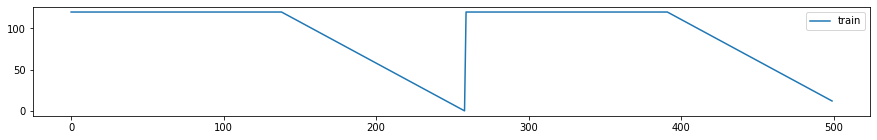

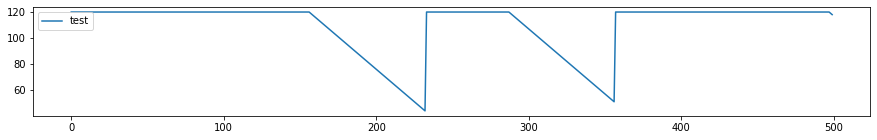

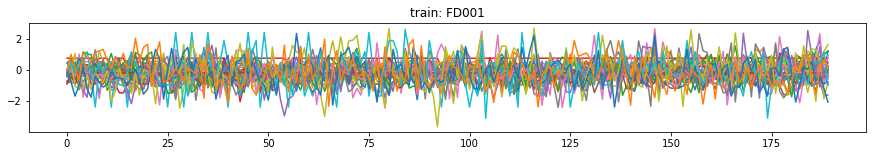

In [212]:
training_data = train_FD003.values
testing_data = test_FD003.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)
# 训练数据集 前面500个数据点所对应的rul 由图中可以看出  都是到零的了
plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))
# 测试数据中前500个数据点对应的tul  可以看到结尾数据的rul 都不是中间
plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: FD00" + str(1))
# 训练数据第一个id的 24个senor的值 可以通过在x轴坐标100的位置 序列的一些 趋势

plt.show()

In [213]:
def batch_generator(training_data, sequence_length=15, window_size = 15):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    engine_ids = list(training_data["engine_id"].unique())
    temp = training_data.copy()
    # 把 每一段后一截给截掉，获取能够跑的index
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # cutoff_cycle 记录下这以后的index就不满足 序列大小的需求的
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 1
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            drop_range = indexes
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle+2].index
            drop_range = list(range(cutoff_cycle_index[0], indexes[-1] + 1))
            
        temp.drop(drop_range, inplace=True)
    indexes = temp.index
    del temp
    

    x_shape = (len(indexes), sequence_length, window_size, 32)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(indexes), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    
    # 第一个数据集
    alt_index = indexes[0]
    for batch_index, index in enumerate(indexes):
        # 因为对齐的原因，都减去了1
        y_batch[batch_index] = training_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        # 本来应该下面这个 for 循环的，但是考虑到循环的嵌套，跑太久了，而且窗口序列之间又有重复，那么减少循环的次数
        # for seq in range(sequence_length):
            # x_batch[index,seq] = training_data.iloc[idx+seq:idx+seq + window_size, 2:-1].values
        
        if index-alt_index==1 and batch_index!=0:
            temp_window = training_data.iloc[index+sequence_length-1:index+sequence_length-1 + window_size, 2:-1].values.reshape(1,window_size,-1)
            x_batch[batch_index] = np.concatenate((x_batch[batch_index-1][1:],temp_window))
        else:
            for seq in range(sequence_length):
                x_batch[batch_index][seq] = training_data.iloc[index+seq:index+seq + window_size, 2:-1].values
        alt_index = index
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [215]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
from tensorflow.compat.v2.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import _standardize_args
from tensorflow.python.keras.utils import generic_utils


In [216]:
sequence_length=9
window_size = 28
kernel_size = 3

In [217]:
x_batch, y_batch =batch_generator(train_FD003,sequence_length=sequence_length,window_size = window_size)
# 这里需要把输入数据增加一个channel层数
x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=2)

In [124]:
from ConvLSTM2D_2 import ConvLSTM2D_2

In [251]:
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D_2(filters=20, kernel_size=(kernel_size, 3),cov_kernel_size=(3, 3),input_shape=(None, window_size, 32, 1), padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(ConvLSTM2D_2(filters=40, kernel_size=(kernel_size, 28),padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(TimeDistributed(Flatten()))
model.add(tf.compat.v2.keras.layers.Dropout(0.5))
model.add(TimeDistributed(Dense(units = 50, activation = "linear")))
model.add(TimeDistributed(Dense(units = 1, activation = "linear")))

# initial_learning_rate = 0.01
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100,
#     decay_rate=0.96,
#     staircase=True)


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam())

In [252]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2_20 (ConvLSTM2 (None, None, 24, 28, 20)  47600     
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 24, 28, 20)  80        
_________________________________________________________________
conv_lst_m2d_2_21 (ConvLSTM2 (None, None, 20, 1, 40)   849760    
_________________________________________________________________
batch_normalization_21 (Batc (None, None, 20, 1, 40)   160       
_________________________________________________________________
time_distributed_30 (TimeDis (None, None, 800)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 800)         0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, None, 50)        

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_batch,y_batch, batch_size=15, epochs=30, validation_split=0.05,callbacks=[callback],)

Train on 20159 samples, validate on 1061 samples
Epoch 1/30
 3015/20159 [===>..........................] - ETA: 1:46 - loss: 1250.5048

# Evaluation

## Tranining Performance

In [ ]:
y_batch_pred = model.predict(x_batch)

In [ ]:
from sklearn.metrics import mean_squared_error
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

## Test Performance

## Evaluation Method 1

In [ ]:
def test_batch_generator(test_data, sequence_length=15, window_size = 15):
    """
    这里的seq 和 win size 必须要和前面training的一致
    """
    engine_ids = list(test_data["engine_id"].unique())
    index_list=[]
    temp = test_data.copy()
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # 找到对应的index，index以前的数据相当于抛弃了，，这个有待改进
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 2
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index
            index_list.append(cutoff_cycle_index.values[0])
            

    del temp
    

    x_shape = (len(index_list), sequence_length, window_size, 32)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(index_list), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    


    for test_index, index in enumerate(index_list):
        y_batch[test_index] = test_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        for seq in range(sequence_length):
            x_batch[test_index][seq] = test_data.iloc[index+seq:index+seq + window_size, 2:-1].values
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [ ]:
x_batch_test, y_batch_test =  test_batch_generator(test_FD003, sequence_length=sequence_length,window_size = window_size)
x_batch_test = np.expand_dims(x_batch_test, axis=4)

In [ ]:
y_batch_pred_test = model.predict(x_batch_test)

In [ ]:
y_batch_pred_test = y_batch_pred_test.reshape(y_batch_pred_test.shape[0],y_batch_pred_test.shape[1])
y_batch_pred_last_values_test = [i[-1] for i in y_batch_pred_test]
y_batch_last_values_test = [i[-1] for i in y_batch_test]

In [ ]:
np.sqrt(mean_squared_error(y_batch_pred_last_values_test, y_batch_last_values_test))

# Visua

In [ ]:
y_batch_test.shape

In [ ]:
y_v = y_batch_test.flatten()

In [ ]:
y_v_pred = y_batch_pred_test.flatten()

In [ ]:
y_v[0]

In [ ]:
y_real = []
y_pre =[]
y = pd.DataFrame()
for i in range (len(y_v)):
    y_real.append(y_v[i])
    y_pre.append(y_v_pred[i])
y['real_y'] =y_real
y['pre_y'] =y_pre

In [ ]:
y = y.iloc[:200,:]

In [ ]:
y[['real_y','pre_y']].plot(figsize=(15,5));